In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
# read in all the words 
words = open('names.txt', 'r').read().splitlines()
print("Nombre de prénoms : ", len(words))
words[:8]

Nombre de prénoms :  32033


['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
chars = sorted(list(set(''.join(words))) + ['.'])
stoi = {s:i for i, s in enumerate(chars)}
itos = {i:s for i, s in enumerate(chars)}
encode = lambda x : stoi[x]
decode = lambda x : itos[x]
print(itos)

{0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}


In [4]:
# build the dataset 

block_size = 3 # context length : how many characters do we take to predict the next one? 
X, Y = [], []
for w in words[:5]:
    print(w)
    context = [0] * block_size # padding with dots. 
    for ch in w + '.':
        ix = encode(ch)
        X.append(context)
        Y.append(ix)
        print(''.join(decode(i) for i in context), '--->', decode(ix))
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
ava
... ---> a
..a ---> v
.av ---> a
ava ---> .
isabella
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .
sophia
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .


In [5]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In [6]:
C = torch.randn((27,2))

In [7]:
C.shape, X.shape, C[X].shape

(torch.Size([27, 2]), torch.Size([32, 3]), torch.Size([32, 3, 2]))

In [8]:
emb = C[X] # (nb_of_blocks, block_size, dimensions) -> (32,3,2)

In [9]:
# first layer -- 
W1 = torch.randn((6, 100))
b1 = torch.randn(100)
# what happen if emb @ W1: 
#  --> mat1 and mat2 shapes cannot be multiplied (96x2 and 6x100)
# solution : torch.reshape or torch.view 
h = emb.view(emb.shape[0], emb.shape[1] * emb.shape[2]) @ W1 + b1
h = torch.tanh(h) # activation layer 
h.shape

torch.Size([32, 100])

In [10]:
# second layer -- 
W2 = torch.randn((100,27))
b2 = torch.randn(27)

logits = h @ W2 + b2 # (32, 27)
# softmax
counts = logits.exp()
prob = counts / counts.sum(1, keepdim=True)
prob[torch.arange(32), Y]

tensor([5.7061e-10, 1.2260e-11, 2.5528e-12, 2.6869e-17, 3.7307e-15, 2.6548e-10,
        2.1250e-01, 2.6613e-12, 9.3059e-11, 1.1373e-10, 1.4364e-04, 1.2203e-12,
        9.4219e-08, 3.7828e-09, 1.7892e-08, 3.2496e-13, 1.1223e-09, 7.1671e-14,
        9.9427e-01, 7.0688e-07, 1.0087e-05, 1.9685e-12, 9.4559e-01, 1.2463e-15,
        2.9260e-11, 2.7322e-13, 1.0054e-09, 3.3420e-10, 3.5707e-11, 1.7046e-09,
        3.4102e-04, 2.8826e-14])

## Rangement

In [11]:
# build the dataset 
block_size = 3 # context length : how many characters do we take to predict the next one? 
X, Y = [], []
for w in words:
    context = [0] * block_size # padding with dots. 
    for ch in w + '.':
        ix = encode(ch)
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

In [12]:
X.shape, Y.shape # dataset

(torch.Size([228146, 3]), torch.Size([228146]))

In [13]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [14]:
sum(p.nelement() for p in parameters) # number of parameters in total

3481

In [15]:
BATCH_SIZE = 32
LEARNING_RATE = 0.1

for p in parameters:
    p.requires_grad = True

for _ in range(1000):

    # minibatch construct
    ix = torch.randint(0, X.shape[0], (BATCH_SIZE, ))

    # forward pass
    emb = C[X[ix]] # (batch_size, block_size, dimensions)
    h = emb.view(emb.shape[0], emb.shape[1] * emb.shape[2]) @ W1 + b1
    h = torch.tanh(h)
    logits = h @ W2 + b2
    # In practice, you never re-write cross_entropy for numerous reasons, numerical behavior, space occupation, faster results ... 
    # counts = logits.exp()
    # prob = counts / counts.sum(1, keepdim=True)
    # loss = -prob[torch.arange(32), Y].log().mean()
    loss = F.cross_entropy(logits, Y[ix])
    

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update 
    for p in parameters:
        p.data += - LEARNING_RATE * p.grad

print(f"loss = {loss.item():.4f}")

loss = 2.6216


Petit ajout sur comment trouver un learning rate intéressant : en tester plusieurs ! 

loss = 8.3616


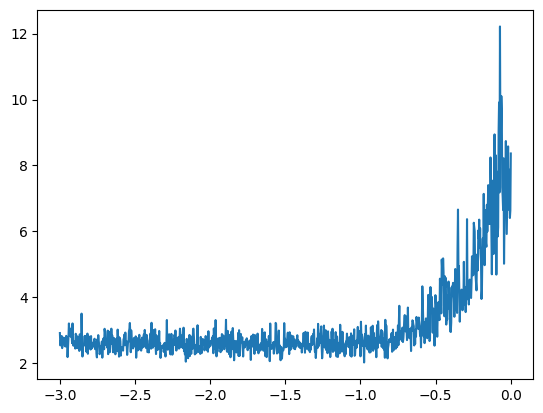

In [16]:
lrs = torch.linspace(-3, 0, 1000)
lre = 10 ** lrs 

BATCH_SIZE = 32

lri = []
lossi = []

for p in parameters:
    p.requires_grad = True

for i in range(1000):

    # minibatch construct
    ix = torch.randint(0, X.shape[0], (BATCH_SIZE, ))

    # forward pass
    emb = C[X[ix]] # (batch_size, block_size, dimensions)
    h = emb.view(emb.shape[0], emb.shape[1] * emb.shape[2]) @ W1 + b1
    h = torch.tanh(h)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])
    
    # backward pass
    for p in parameters:
        p.grad = None

    loss.backward()

    lr = lre[i]
    
    for p in parameters:
        p.data += - lr * p.grad

    # track stats 
    lri.append(lrs[i])
    lossi.append(loss.item())

print(f"loss = {loss.item():.4f}")

plt.plot(lri, lossi)

On voit qu'un exposant autour de -1 est intéressant, soit un learning_rate autour de 0.1

### don't overfit : train/val/test split

In [17]:
# 80%, 10%, 10%
# train, val, test
# train parameters, train hyperparameters, validate all at the end independantly 
import random 
random.seed(42)

def build_dataset(words):
    block_size = 3 # context length : how many characters do we take to predict the next one? 
    X, Y = [], []
    for w in words:
        context = [0] * block_size # padding with dots. 
        for ch in w + '.':
            ix = encode(ch)
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)

    return X, Y


random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

X_train, Y_train = build_dataset(words[:n1])
X_val, Y_val = build_dataset(words[n1:n2])
X_test, Y_test = build_dataset(words[n2:])

X_train.shape, X_val.shape, X_test.shape

(torch.Size([182625, 3]), torch.Size([22655, 3]), torch.Size([22866, 3]))

In [21]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 300), generator=g)
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

BATCH_SIZE = 32
LEARNING_RATE = 0.1

def train(steps):
    for p in parameters:
        p.requires_grad = True

    for _ in range(steps):

        # minibatch construct
        ix = torch.randint(0, X.shape[0], (BATCH_SIZE, ))

        # forward pass
        emb = C[X[ix]] # (batch_size, block_size, dimensions)
        h = emb.view(emb.shape[0], emb.shape[1] * emb.shape[2]) @ W1 + b1
        h = torch.tanh(h)
        logits = h @ W2 + b2
        loss = F.cross_entropy(logits, Y[ix])
        
        # backward pass
        for p in parameters:
            p.grad = None
        loss.backward()
        # update 
        for p in parameters:
            p.data += - LEARNING_RATE * p.grad


In [27]:
train(10000)

emb = C[X_train] # (batch_size, block_size, dimensions)
h = emb.view(emb.shape[0], emb.shape[1] * emb.shape[2]) @ W1 + b1
h = torch.tanh(h)
logits = h @ W2 + b2
train_loss = F.cross_entropy(logits, Y_train)

    
emb = C[X_val] # (batch_size, block_size, dimensions)
h = emb.view(emb.shape[0], emb.shape[1] * emb.shape[2]) @ W1 + b1
h = torch.tanh(h)
logits = h @ W2 + b2
val_loss = F.cross_entropy(logits, Y_val)
print("Train loss = ", train_loss.item())
print("Val loss = ", val_loss.item())

Train loss =  2.5102477073669434
Val loss =  2.5141053199768066


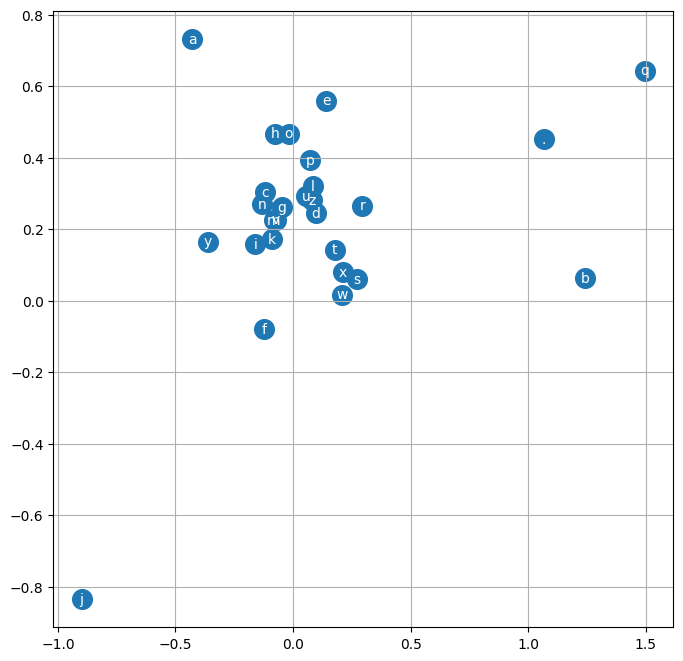

In [28]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [29]:
# sample from the model
g = torch.Generator().manual_seed(2147483647)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

juwrindianasia.
pristy.
aidy.
gri.
ritolian.
arean.
dainaraydaileigar.
dedailawiar.
dinjaicarlaryariarmarthya.
demmerninasyajarsandynora.
yar.
grary.
jazdynn.
torin.
wynsleighasnasiaironiah.
dagossintin.
ili.
rinara.
thariaryrsli.
ishawyar.
